In [1]:
%matplotlib inline
import os
from PIL import Image
from PIL import ImageEnhance
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import asarray
from itertools import combinations
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import matplotlib.animation as animation
import ipywidgets as widgets
import cv2 
import pyautogui
import scipy as sp
from ipywidgets import interact
from scipy.optimize import curve_fit
import imageio

In [2]:
def ImageRead(dir_name):
    """
    This function is to read all the images inside the directory folder into the python script. 
    """
    image = []
    for filename in os.listdir(f'gopro_data/{dir_name}'):
        image.append(cv2.imread(f"gopro_data/{dir_name}/{filename}",cv2.IMREAD_GRAYSCALE))
    return image

In [3]:
def get_break_pixel(data, mode = 0 , sms=3, square_band=False, loc=0.5, white_threshold=230, limit = 255):
    """
    From a given greyscale image (2D numpy array), returns the idx and idy of the first white pixel from the top
    
    data: 2D array
    sms (square mask sizem odd_number): averages the pixels wihtin a mask of size sms to find the white pixel, default 1
    loc: location of the center column used to find the white pixel, default 0.5 (so in the center of the image)
    white_threshold: threshold used for considering the first white pixel, i.e. pixel is white if value > white_threshold
    square_band (boolean): use either a square band (True), or a horizontal band (False)
    """
    idx = int(data.shape[1] * loc)
    diff = sms // 2    
    
    if diff == 0:
        data_col = data[:,idx]
    elif not square_band:
        data_col = np.mean(data[:,idx-diff:idx+diff], axis=1)
    else:
        data_col = np.zeros(data.shape[0])
        for i in range(len(data_col)):
            data_col[i] = np.mean(data[i-diff:i+diff, idx-diff:idx+diff])
    
    if mode == 0:
        idy_white = (list(data_col>white_threshold and data_col<= limit)).index(True)
        idy = np.min(idy_white)
    elif mode == 1:
        idy_white = [i for i, x in enumerate(data_col) if x > white_threshold]
        idy = idy_white
        
    return idy, idx

In [3]:
def get_break_sequence(dir_name, mode, sms=3, square_band=False, loc=0.5, white_threshold=230, limit = 255):
    
    """
    returns array with breaker pixel coordinates
    
    dir_name (string): name of directory containing gopro data
    sms (square mask sizem odd_number): averages the pixels wihtin a mask of size sms to find the white pixel, default 1
    loc: location of the center column used to find the white pixel, default 0.5 (so in the center of the image)
    white_threshold: threshold used for considering the first white pixel, i.e. pixel is white if value > white_threshold
    
    """
    
    breaker_sequence = []
    
    for filename in os.listdir(f'gopro_data/{dir_name}'):
        p = cv2.imread(f"gopro_data/{dir_name}/{filename}",cv2.IMREAD_GRAYSCALE)     
        try:
            idy, idx = get_break_pixel(p, mode, sms=sms, square_band=False, loc=loc, white_threshold=white_threshold)
        except:
            print("can't assign None to (idy, idx)")
        
        breaker_sequence.append((idy, idx))  
    return breaker_sequence
        

In [5]:
def peak_detection(data, image, c_coordinate, init, end, Hz, threshold = -85):
    '''
    Note that using this function requires a good wwave bore detection from function "get_break_sequence"
    This fucntion is to detect the breaking location of the succesive waves from a single column.
    data: single column (specific r coordinates) with continuous time period.
    image: one image for showing the breaking points.
    threshold: c coordinate difference for breaking location iteration.
    c_coordinate: the specific column.
    init: sequence of the acquired first importing images.
    end: sequence of the acquired end importing images.
    '''
    data = data[init:end]
#     print(len(data))
    
    
    # derive the furthest points
    k = []
    try:
        for i in range(len(data)):
            k.append(data[i][0][0])
    except IndexError:
        pass
#         k.append(k[-1])
    
    mark = []
    try:
        for i in range(len(data)-1):
            diff =  data[i+1][0][0]-data[i][0][0] 
            if diff < threshold:
                mark.append(data[i+1][0][0])         
    except IndexError:       
         pass   
            
    o = np.ones(len(mark))*c_coordinate  
  
    
    # Create time series for the furthest breaking points
    indices = []
#     a = []
#     time_br = []
    
    for i in range(len(mark)):
        indices.append([j for j, x in enumerate(k) if x == mark[i]]) 
    value = []
    mini = min(indices[0])
    mini2 = mini
    final = []
    for i in range(1,len(indices)):
        c = indices[i]
    
        def sub(a,mini):
            substract = []
            tem_storage = []
            for j in range(len(a)):
                substract.append(a[j] - mini)
                if substract[j] > 0:
                    tem_storage.append(a[j])
            return tem_storage
    
        tem_storage = sub(c, mini)
        value.append(min(tem_storage))
        mini = value[i-1]
        final.append(mini)
    final = np.hstack((mini2,final))
    time_br = final * (1/Hz)
        
    # Create time series for the all the data points
    if init == 0:
        start_time = 0
    else:
        start_time = (init-0)/Hz
        
    endtime = end/Hz
    time = np.arange(start_time, endtime, 1/Hz)
    
    
    # Depicting the breaking locations on the image 
    plt.figure(figsize = (12,8))
    plt.plot(o,mark,'b.')
    plt.imshow(image,cmap = 'gray')
    plt.show()
    
    # Depicting the breaking locations on the scatter plot for checking
    plt.figure(figsize = (12,8))
#     plt.scatter(time,k, label = 'Algorithm Detected Breaking Location')
    plt.scatter(time_br, mark, label = 'Predicted Breaking Location')
    plt.legend()
    plt.xlabel("time[s]",fontsize=12)
    plt.ylabel("C [pixel] (image coordinates)",fontsize=12)
    
    plt.gca().invert_yaxis()
    return mark

In [4]:
def remove_outlier(lower,upper,data):
    a = []
    for i in range(len(data)):
        if data[i] < upper and data[i] > lower:
            a.append(data[i])
    return a

# Global Parameters 

In [5]:
filename = 'gopro_data/0926'
imagefile = "0926"

In [6]:
N = len(os.listdir(filename))-1 # Number of the images 
images = ImageRead(imagefile) # Read the data 
f = 2 # sampling frequency: 2Hz 

# Location of breaking waves

In [8]:
# Breaking points at the furthest Position
breaking_points_detect = get_break_sequence(imagefile, mode = 1, loc=0.475, white_threshold = 230)

can't assign None to (idy, idx)


UnboundLocalError: local variable 'idy' referenced before assignment

In [ ]:
%run -i breaking_points_check
breaking_points_check(images, breaking_points_detect, mode = 1, init = 0, seq = 5)

<Figure size 432x288 with 0 Axes>

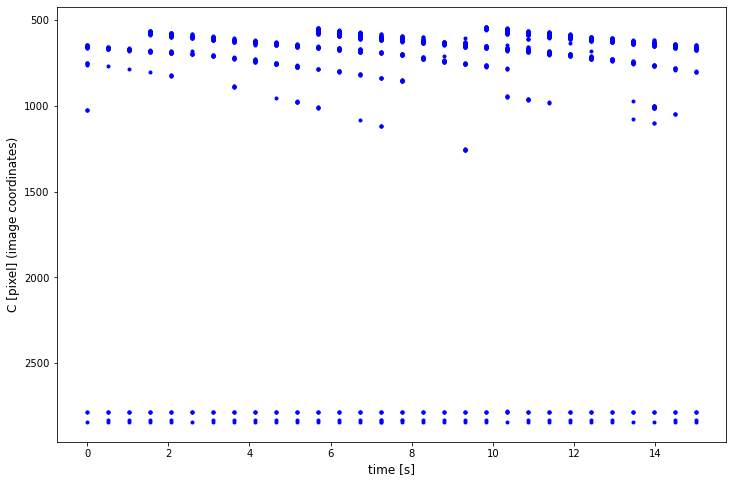

In [11]:
%run -i vplot
vplot(breaking_points_detect, 2, 0, 1000)   

-----

In [12]:
# breaking_location = peak_detection(breaking_points_detect, images[0], c_coordinate=1900, init=0, end = 1200 , Hz = 2, threshold = -40)
# print(breaking_location)

In [13]:
breaking_points_detect[0][0]

[644,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 657,
 658,
 659,
 660,
 661,
 748,
 749,
 750,
 758,
 759,
 1022,
 1023,
 1024,
 2785,
 2786,
 2845]

In [14]:
# breaking_location7 = remove_outlier(450,600,breaking_location)
# print(breaking_location7)

# Wave Front (Bore) Propagation Velocity

In [15]:
%run -i wavefront_speed
Bore = Wavefront_speed((679,2000), 2, imagefile, loc=0.475, white_threshold=235)
display(Bore[0])
display(Bore[1])

The first list is Speed and the second list is Coordinates


[4074.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[(748, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900),
 (2785, 1900)]

<Figure size 432x288 with 0 Axes>

In [16]:
breaking_points_check(images, Bore[1], mode = 0, init = 0, seq = 29)

Mode 0


interactive(children=(IntSlider(value=14, description='frame', max=29), Output()), _dom_classes=('widget-inter…

<function __main__.breaking_points_check.<locals>._show(frame=(0, 29))>

In [17]:
velocity_c_coordinate = Bore[1][0:15]

In [18]:
print(velocity_c_coordinate)

[(748, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900), (2785, 1900)]


# Zoom in function (unsolved)

In [19]:
base_img = images[0]
ref = []
img = base_img
zoom = 1
min_zoom = 1
max_zoom = 5

def select_roi(event, x, y, flags, param):
    global base_img, zoom, min_zoom, max_zoom, ref
    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            zoom *= 1.1
            zoom = min(zoom, max_zoom)
        else:
            zoom /= 1.1
            zoom = max(zoom, min_zoom)

        img = base_img.copy()

        # Calculate zoomed-in image size
        new_width = round(img.shape[1] / zoom)
        new_height = round(img.shape[0] / zoom)

        # Calculate offset
        x_offset = round(x - (x / zoom))
        y_offset = round(y - (y / zoom))

        # Crop image
        img = img[y_offset : y_offset + new_height,
                  x_offset : x_offset + new_width]

        # Stretch image to full size
        img = cv2.resize(img, (base_img.shape[1], base_img.shape[0]))
        cv2.imshow("Selected area", img)
        
    if event == 1:
        ref.append([x, y])
        
cv2.namedWindow("Selected area",cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Selected area", select_roi)
# cv2.setMouseCallback('image', mouse_click )
cv2.imshow("Selected area", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[2046  717]
 [2060  586]
 [2040  523]
 [2050  509]
 [2075  494]]


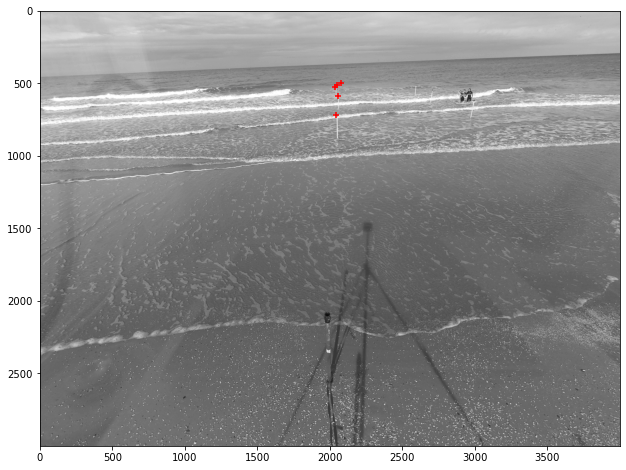

In [31]:
ref = np.array(ref)
plt.figure(figsize = (12,8))
plt.imshow(images[0],cmap = 'gray')
plt.scatter(ref[:,0],ref[:,1],c = 'r', marker = '+')
print(ref)

# Coordinate Conversion

In [21]:
GPS = pd.read_csv(('gps_data/coordinates.txt'), delimiter=',')
display(GPS)

,X,Y,Z,Accuracy,labels
0,72422.984,452119.801,0.827,0.010,GoPro
1,72409.749,452131.948,0.321,0.010,1
2,72399.133,452141.747,0.029,0.010,2
3,72390.365,452149.361,-0.124,0.009,3
4,72381.722,452157.418,-0.487,0.010,4
5,72373.330,452166.208,-0.750,0.010,5
6,72364.268,452173.996,-1.246,0.014,6
7,72397.936,452156.630,-0.121,0.013,Ref


In [22]:
# Pairing the corresoonding image points and GPS Data 
reference_points = ref
real_points = np.array([GPS['X'][1:6], GPS['Y'][1:6]]).T

head = np.array([72420.368,452122.958]) # Assume this data is the auxiliary pole
real_points_fake = np.vstack((head,real_points))

print(reference_points)
print(real_points)

[[2046  717]
 [2060  586]
 [2040  523]
 [2050  509]
 [2075  494]]
[[ 72409.749 452131.948]
 [ 72399.133 452141.747]
 [ 72390.365 452149.361]
 [ 72381.722 452157.418]
 [ 72373.33  452166.208]]


C:\Users\sagi8\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

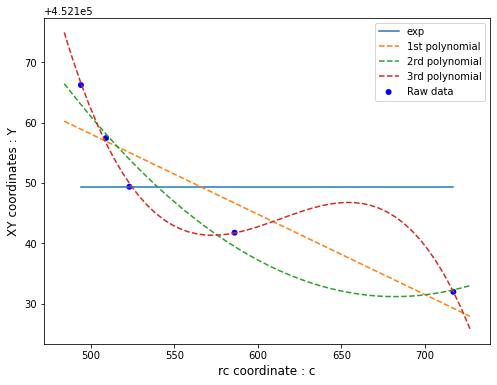

In [32]:
%run -i single_conservation
p_1, p_2, p_3 = single_conversion(reference_points,real_points)

# Real Coordinates

In [24]:
def convertion(reference,real,data):
    z_convert = np.polyfit(reference,real, 1)
    p_convert = np.poly1d(z_convert)
    Y = p_convert(data)
    return Y

In [25]:
velocity_Y_coordinates= convertion(reference_points[:,1],real_points[:,1],velocity_c_coordinate)
display(velocity_Y_coordinates[:,0])
np.savetxt('velocity_W3_coordinates', (velocity_Y_coordinates), delimiter=',')

array([452125.10005509, 451854.13718692, 451854.13718692, 451854.13718692,
       451854.13718692, 451854.13718692, 451854.13718692, 451854.13718692,
       451854.13718692, 451854.13718692, 451854.13718692, 451854.13718692,
       451854.13718692, 451854.13718692, 451854.13718692])

In [26]:
def velocity(data,Hz):
    v = []
    for i in range(len(data)-1):
        v.append((data[i+1] - data[i]) / (1/Hz))
#         v = [abs(ele) for ele in w1v]
    return v

In [27]:
w1v = velocity(velocity_Y_coordinates[:,0],2) 

In [28]:
print(w1v)

[-541.9257363324286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


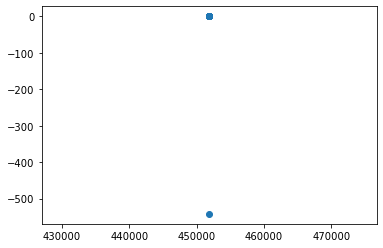

In [29]:
plt.figure()
plt.scatter(velocity_Y_coordinates[1:,0], w1v)
plt.show()

-----------------------------------------------------------------------------

In [30]:
import datetime

dataframe = pd.read_csv('breaker_location.csv',sep = ",", parse_dates=['t'])

dataframe.drop('Unnamed: 0', inplace=True, axis=1)

display(dataframe)
seq = dataframe[dataframe["t"] == datetime.datetime.strptime('2023-09-25 11:10:00', '%Y-%m-%d %H:%M:%S')].breaker_location

print(seq)


FileNotFoundError: [Errno 2] No such file or directory: 'breaker_location.csv'

In [ ]:
Y = convertion([1,2],[7,8],5)
print(Y)

# Image Calibration

In [ ]:
def caliProjrx2yz(rc,yz):
    """
    This function will produce a projection matrix to bond the 
    visable reference points on the images and the them in the real word.
    rc is the image coordinate and yz is the real coordinate.
    """
    # Unwrap 2D (row,column) and 2D (y,z) positions:
    r = rc[:,0]; c = rc[:,1];
    y = yz[:,0]; z = yz[:,1];
    n = len(r);
    
    # set up system of linear equations Q*u = s
    # where u = [a11 a12 a21 a22 a31 a32 b1 b2 b3]':
    Q = np.zeros((n+3,9));  
    s = np.zeros((n+3,1));
    
    # build matrix Q and independent vector s:
    for i in range(n):
        # line 2*i-1 of matrix Q:
        Q[2*i,0] = -z[i]; Q[2*i,1] = -y[i]; Q[2*i,2] = 0;
        Q[2*i,3] = 0.; Q[2*i,4] = z[i]*r[i]; Q[2*i,5] = y[i]*r[i]; 
        Q[2*i,6] = -1; Q[2*i,7] = 0; Q[2*i,8] = r[i];
        # line 2*i of matrix Q:
        Q[2*i+1,0] = 0.; Q[2*i+1,1] = 0.; Q[2*i+1,2] = -z[i];	
        Q[2*i+1,3] = -y[i]; Q[2*i+1,4] = z[i]*c[i]; Q[2*i+1,5] = y[i]*c[i];
        Q[2*i+1,6] = 0; Q[2*i+1,7] = -1; Q[2*i+1,8] = c[i];
        # independent vector s
        s[2*i,0] = 0.; s[2*i+1,0] = 0.;
        
    # Add a line to avoid trivial zero solution to the homogeneous system
    Q[2*n-1,:] = np.zeros((1,9));
    Q[2*n-1,6] = 1;
    s[2*n-1,0] = 1;
    
    # Solve system:
    # u = Q\s
    sol = np.linalg.lstsq(Q,s,rcond=None) 

#     num_vars = Q.shape[1]
#     rank = np.linalg.matrix_rank(Q)
#     if rank == num_vars:              
#         sol = np.linalg.lstsq(Q, s)[0]    # not under-determined
#     else:
#         for nz in combinations(range(num_vars), rank):    # the variables not set to zero
#             try: 
#                 sol = np.zeros((num_vars, 1))  
#                 sol[nz, :] = np.asarray(np.linalg.solve(Q[:, nz], s))
#                 print(sol)
#             except np.linalg.LinAlgError:     
#                 pass  
    
    # Construct projection matrix Proj = [A|b]:
    Proj = np.ones((3,3))
    Proj[0,0] = sol[0][0]; Proj[0,1] = sol[0][1]; Proj[0,2] = sol[0][6]; 
    Proj[1,0] = sol[0][2]; Proj[1,1] = sol[0][3]; Proj[1,2] = sol[0][7];
    Proj[2,0] = sol[0][4]; Proj[2,1] = sol[0][5]; Proj[2,2] = sol[0][8];
    
    return Proj

In [ ]:
def rc2yz(Proj,rc):
    r = rc[:,0]; c = rc[:,1]; n = len(r);
    Proj_inv = np.linalg.inv(Proj);
    yz = [];
    for i in range(n):
        rc1 = [r[i],c[i],0];
        zylamda = Proj_inv*rc1;
        
        z = zylamda[0]/ zylamda[2];
        y = zylamda[1]/ zylamda[2];
        yzt = [y,z];
        yz = [yz,yzt];
    return yz

In [ ]:
ref_points = np.matrix(ref_points).T
print(ref_points)
yz = np.matrix([[GPS['X'][1], GPS['Y'][1]],
               [GPS['X'][2], GPS['Y'][2]]])
print(yz)

In [ ]:
Proj = caliProjrx2yz(ref_points,yz)
print(Proj)
XReso = 4000;
ZReso = 3000; 
boundarypoints =np.array([[0,0], [XReso,ZReso]]);
print(boundarypoints)
yz = rc2yz(Proj,boundarypoints)
# print(yz)

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
realxz = np.array([[yz[1][0][0], yz[1][0][1]],[yz[1][1][0], yz[1][1][1]]])
print(realxz)

In [ ]:
sp.ndimage.map_coordinates

In [ ]:
Xmin = realxz[1,0]
Xmax = realxz[1,1]
Zmin = realxz[0,0]
Zmax = realxz[0,1]
dx = int((Xmax - Xmin)/XReso)
dz = int((Zmax - Zmin)/ZReso)
x = np.linspace(Xmin, Xmax, XReso)
z = np.linspace(Zmin, Zmax, ZReso)
xv, zv = np.meshgrid(x, z, indexing='ij')
plt.plot(xv, zv, color='k', linestyle='none')
plt.show()


In [ ]:
np.set_printoptions(threshold=sys.maxsize)
xtest_real = x
# print(xtest_real)
ytest_real = z
# print(ytest_real)
xtest_image = np.linspace(0,3000,3000)
ytest_image = np.linspace(0,4000,4000)
interp = RegularGridInterpolator((xtest_image,ytest_image), np.flipud(numpydata), bounds_error=False, fill_value=None)


r, c = np.meshgrid(xtest_real, ytest_real, indexing='xy')
# print(r)
# print(c)
real_image = (interp((r,c))/16)
# print(real_image[0:40,0:60])

In [ ]:
plt.imshow(real_image, cmap = 'gray')
plt.show()

In [ ]:
Image.fromarray